In [3]:
import pandas as pd

information_technology = pd.read_csv("data/information_technology.csv")
information_technology.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Nov 30, 2023",4554.87,4569.89,4537.24,4567.80,4567.80,5399300000
1,"Nov 29, 2023",4571.84,4587.64,4547.15,4550.58,4550.58,4418760000
2,"Nov 28, 2023",4545.55,4568.14,4540.51,4554.89,4554.89,3586240000
3,"Nov 27, 2023",4554.86,4560.52,4546.32,4550.43,4550.43,3403990000
4,"Nov 24, 2023",4555.84,4560.31,4552.80,4559.34,4559.34,1639500000


In [6]:
import numpy as np

def read_and_process_data(sector_name_list):
    merged_df = None
    for sector_name in sector_name_list:
        sector_df = pd.read_csv(sector_name + '.csv')
        sector_df['date'] = pd.to_datetime(sector_df['Date'])
        sector_df[sector_name] = sector_df['Adj Close']
        sector_df.drop(columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'],
                        inplace = True)

        if merged_df is None:
            merged_df = sector_df
        else:
            merged_df = merged_df.merge(sector_df, how = 'inner', on = 'date')
    merged_df.set_index('date', inplace = True)
    merged_df.dropna(inplace = True)
    return np.round((merged_df - merged_df.mean())/merged_df.std(), 1)


df = read_and_process_data(['data/information_technology', 'data/health_care'])
df.head()

,data/information_technology,data/health_care
date,,
2023-11-30,1.3,1.1
2023-11-29,1.3,1.1
2023-11-28,1.3,1.0
2023-11-27,1.3,1.1
2023-11-24,1.3,1.1


In [7]:
df.describe()

,data/information_technology,data/health_care
count,1257.000000,1257.000000
mean,0.000716,0.001591
std,0.999199,1.001041
min,-2.300000,-2.000000
25%,-1.000000,-1.000000
50%,0.200000,0.100000
75%,0.900000,1.000000
max,1.700000,2.000000


In [8]:
states = set()
for row in df.iterrows():
    new_state = []
    for c in row[1].items():
        new_state.append(c[1])
    states.add(tuple(new_state))

index = pd.MultiIndex.from_tuples(list(states), names=["information_technology", "health_care"])
policy = pd.DataFrame(0, index = index, columns = ['buy_buy', 'buy_sell', 'sell_sell', 'sell_buy'])
policy = policy.sort_index()
policy.head()

buy_buy  buy_sell  sell_sell  sell_buy
information_technology health_care                                        
-2.3                   -1.9               0         0          0         0
-2.2                   -1.9               0         0          0         0
-2.1                   -2.0               0         0          0         0
                       -1.8               0         0          0         0
                       -1.3               0         0          0         0

In [10]:
import random

def find_action(policy, current_value):
    if policy.loc[current_value, :].sum().sum() == 0:
        return random.choice(['buy_buy', 'buy_sell', 'sell_sell', 'sell_buy'])

    return policy.columns[np.argmax(policy.loc[current_value, :].values)]

def update_policy(reward, current_state_value, action):
    LEARNING_RATE = 0.1
    MAX_REWARD = 10
    DISCOUNT_FACTOR = 0.05

    return LEARNING_RATE * (reward + DISCOUNT_FACTOR * MAX_REWARD - policy.loc[current_state_value, action])

past_state_value = (0, 0)
past_action = 'buy_buy'
total_reward = 0
rewards = []

for idx, row in df.iterrows():
    current_state_value = (row['data/information_technology'], row['data/health_care'])
    action = find_action(policy, current_state_value)

    if past_action == 'buy_buy':
        reward = current_state_value[0] - past_state_value[0]
        reward += current_state_value[1] - past_state_value[1]
    elif past_action == 'buy_sell':
        reward = current_state_value[0] - past_state_value[0]
        reward += past_state_value[1] - current_state_value[1]
    elif past_action == 'sell_sell':
        reward = past_state_value[0] - current_state_value[0]
        reward += past_state_value[1] - current_state_value[1]
    else:
        reward = past_state_value[0] - current_state_value[0]
        reward += current_state_value[1] - past_state_value[1]

    total_reward = total_reward + float(reward)
    policy.loc[current_state_value, action] = policy.loc[current_state_value, action] + \
            update_policy(reward, current_state_value, action)

    rewards.append(total_reward)
    past_actions = current_state_value

/tmp/ipykernel_7033/3181161926.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.29000000000000004' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  policy.loc[current_state_value, action] = policy.loc[current_state_value, action] + \
/tmp/ipykernel_7033/3181161926.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.27999999999999997' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  policy.loc[current_state_value, action] = policy.loc[current_state_value, action] + \
/tmp/ipykernel_7033/3181161926.py:39: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.26' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  policy.loc[c

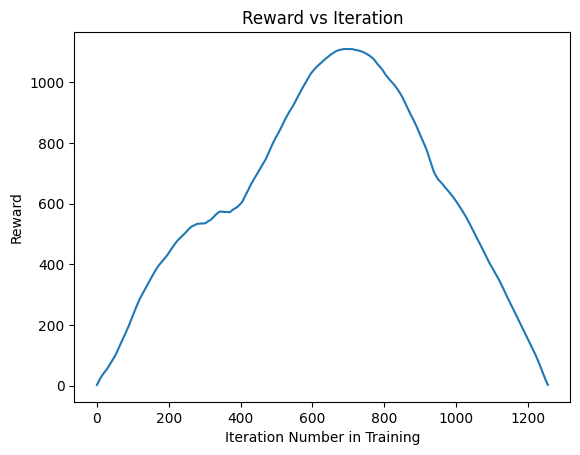

In [11]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.title('Reward vs Iteration')
plt.xlabel('Iteration Number in Training')
plt.ylabel('Reward');

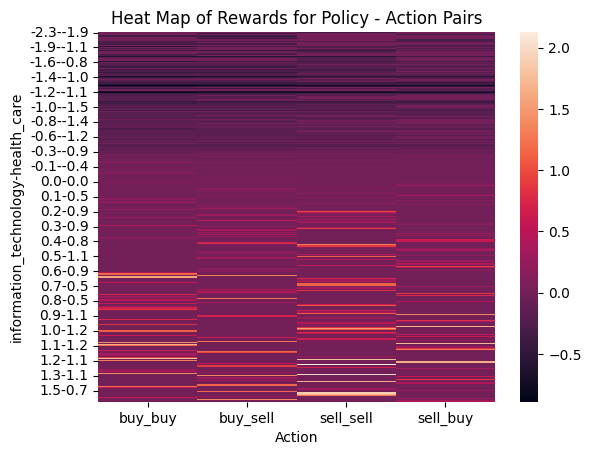

In [12]:
import seaborn as sns
sns.heatmap(policy.sort_index())
plt.title('Heat Map of Rewards for Policy - Action Pairs')
plt.xlabel('Action');

In [13]:
positively_reinforced = policy[policy > 0]
positively_reinforced.describe()

,buy_buy,buy_sell,sell_sell,sell_buy
count,46.000000,50.000000,60.000000,48.000000
mean,0.620456,0.468637,0.667991,0.519330
std,0.484776,0.416613,0.540606,0.415118
min,0.030000,0.010000,0.019000,0.070000
25%,0.232500,0.165353,0.267500,0.252500
50%,0.522500,0.315000,0.514900,0.356150
75%,0.855664,0.664875,1.001277,0.609566
max,1.784092,1.358821,2.127187,1.693436


In [14]:
negatively_reinforced = policy[policy < 0]
negatively_reinforced.describe()

,buy_buy,buy_sell,sell_sell,sell_buy
count,90.000000,85.000000,77.000000,65.000000
mean,-0.261311,-0.254023,-0.240626,-0.239892
std,0.167647,0.157606,0.153464,0.149932
min,-0.890262,-0.778069,-0.778069,-0.778069
25%,-0.322250,-0.323000,-0.270000,-0.304000
50%,-0.218400,-0.220000,-0.210000,-0.200000
75%,-0.160000,-0.150000,-0.160000,-0.150000
max,-0.010000,-0.010000,-0.010000,-0.010000


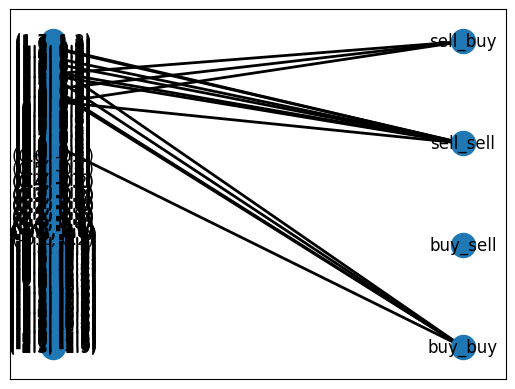

In [15]:
import networkx as nx
from networkx.algorithms import bipartite

G = nx.Graph()
G.add_nodes_from(policy.index.values, bipartite=0)
G.add_nodes_from(policy.columns.values,bipartite=1)

edges = []
for i, row in policy.iterrows():
    row = row.values
    max_idx = np.argmax(row)
    amax = row[max_idx]
    if amax >= 1.4:
        edges.append((i, policy.columns[max_idx]))

G.add_edges_from(edges)
nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G, policy.index.values), width = 2)

In [16]:
for edge in G.edges(['sell_sell']):
    print(edge)

('sell_sell', (1.0, 1.0))
('sell_sell', (1.2, 1.0))
('sell_sell', (1.2, 1.4))
('sell_sell', (1.3, 1.0))
('sell_sell', (1.3, 1.7))
('sell_sell', (1.5, 0.9))
('sell_sell', (1.5, 1.0))


In [17]:
for edge in G.edges(['sell_buy']):
    print(edge)

('sell_buy', (1.0, 0.8))
('sell_buy', (1.1, 1.0))
('sell_buy', (1.2, 1.2))


In [20]:
for edge in G.edges(['buy_sell']):
    print(edge)

In [19]:
for edge in G.edges(['buy_buy']):
    print(edge)

('buy_buy', (0.6, 1.5))
('buy_buy', (1.1, 0.9))
('buy_buy', (1.1, 1.1))
('buy_buy', (1.2, 0.9))
('buy_buy', (1.3, 0.9))
